### import modules

In [179]:
import numpy as np
import pandas as pd

import time
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

### Data Preprocessing

In [180]:
data = pd.read_csv("../AdaBoost-GRU&Sentiment(1w)/data.csv", index_col = 0)

In [181]:
data.head()

,Open,compound
0,22869.90,0.150577
1,22862.33,0.123553
2,22907.00,0.102977
3,22911.60,0.117120
4,22890.44,0.115298


In [183]:
plt.rcParams["figure.figsize"] = (15,10)

Text(0.5, 1.0, 'sentiment score')

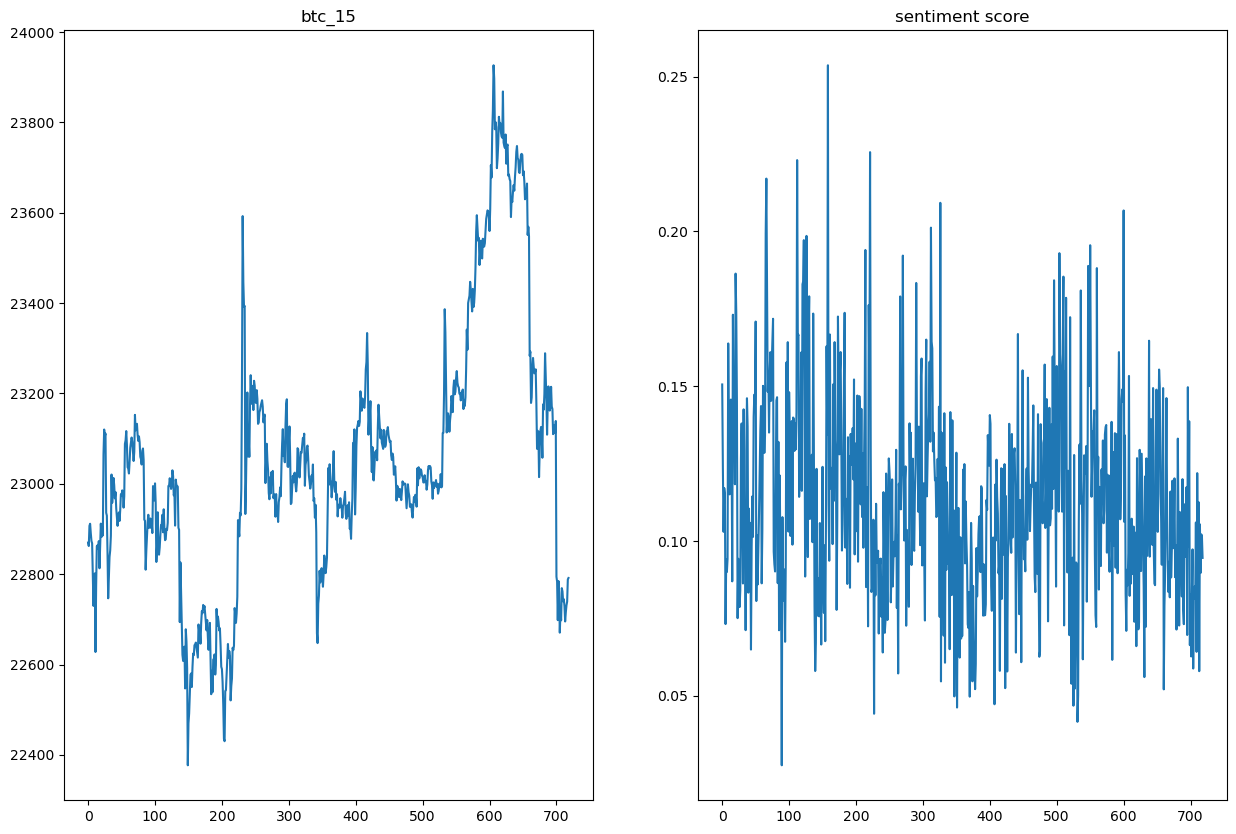

In [184]:
plt.subplot(1,2,1)
plt.plot(data['Open'])
plt.title('btc_15')
plt.subplot(1,2,2)
plt.plot(data['compound'])
plt.title('sentiment score')

### MAE, MSE, RMSE

In [185]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

## Preprocessing

In [186]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

data1 = data.copy()

# 시차 특성 생성 함수
def create_lag_features(df, lag_count):
    for lag in range(1, lag_count + 1):
        df[f'Open_lag_{lag}'] = df['Open'].shift(lag)
        df[f'compound_lag_{lag}'] = df['compound'].shift(lag)
    return df

# 시차 특성 생성 
lag_count = 168
data_lagged = create_lag_features(data1, lag_count)
data_lagged.dropna(inplace=True) # NaN 값을 제거

# 특성(X)과 타겟(y) 설정
X = data_lagged.drop(['Open'], axis=1)
y = data_lagged['Open']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## SVR

In [187]:

# parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param={'C':[1,5,10,20,40,100],
      'gamma':[.001, .01, .1, .25, .5, 1]}
GS=GridSearchCV(SVR(),param, cv=3)
GS.fit(X_train, y_train)
print(GS.best_params_)
print(GS.best_score_)


{'C': 100, 'gamma': 0.001}
-0.054036514090948305


In [188]:
from sklearn.svm import SVR
# SVR 모델 구축 및 훈련
svr = SVR(C=20, gamma=0.001, epsilon=0.2, kernel='rbf')
svr.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred_svr = svr.predict(X_test)
rmse_svr = mean_squared_error(y_pred_svr, y_test)**0.5
print('RMSE of SVR(Scale X):', rmse_svr)


RMSE of SVR(Scale X): 262.50551079432336


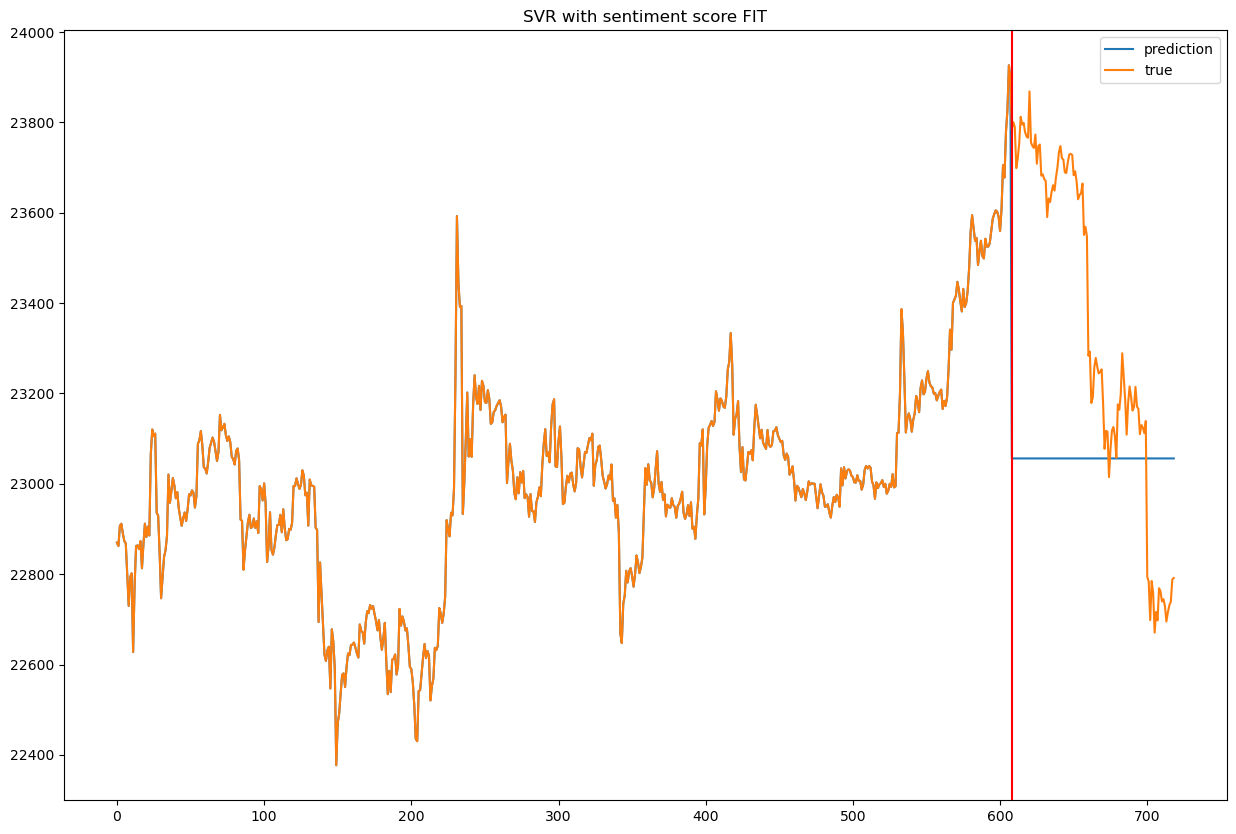

In [189]:
y_pred_svr_series = np.hstack([data['Open'][:-len(y_pred_svr)].reset_index(drop=True), pd.DataFrame(y_pred_svr).squeeze(1)]) 
plt.plot(y_pred_svr_series, label='prediction')
plt.plot(data['Open'], label='true')
plt.axvline(x=len(data['Open'])-len(y_pred_svr), color='r')
plt.legend()
plt.title('SVR with sentiment score FIT')
plt.show()

## RandomForest

In [190]:
from sklearn.ensemble import RandomForestRegressor
# parameter tuning
params = { 'n_estimators' : [20, 50, 100],
           'max_depth' : [1, 3, 6]
            }

rf = RandomForestRegressor(random_state=0)
grid_cv = GridSearchCV(rf, param_grid=params, cv=5)
grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)
print(grid_cv.best_score_)

{'max_depth': 6, 'n_estimators': 100}
0.9613036921129489


In [191]:
from sklearn.ensemble import RandomForestRegressor

# 랜덤 포레스트 모델 구축 및 훈련
rf = RandomForestRegressor(n_estimators=100, max_depth=6, random_state=42)
rf.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred_rf = rf.predict(X_test)
rmse_rf = RMSE(y_pred_rf, y_test)
print('RMSE of RF:', rmse_rf)

RMSE of RF: 6.73e+01


In [195]:
y_test-y_pred_rf

714    -1.475738
249    34.613848
308    13.147518
247   -12.203489
439   -25.188451
         ...    
413   -17.016289
386   -33.103144
344    53.198679
551    51.151867
186   -75.343732
Name: Open, Length: 111, dtype: float64

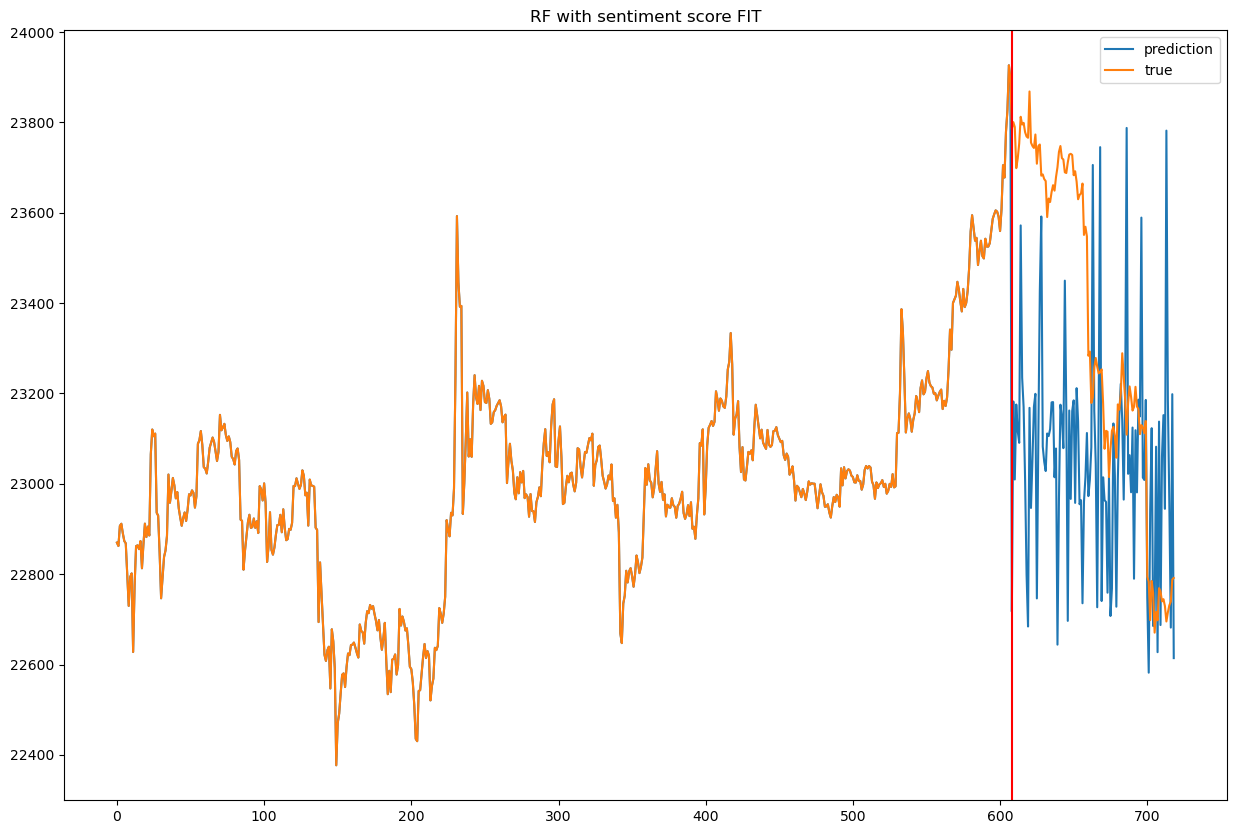

In [192]:
y_pred_rf_series = np.hstack([data['Open'][:-len(y_pred_rf)], y_pred_rf]) 
plt.plot(y_pred_rf_series, label='prediction')
plt.plot(data['Open'], label='true')
plt.axvline(x=len(data['Open'])-len(y_pred_rf), color='r')
plt.legend()
plt.title('RF with sentiment score FIT')
plt.show()